<a href="https://colab.research.google.com/github/ameyas1/Stock_prediction/blob/master/timeseries_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install yfinance package.
!pip install yfinance 

  Created wheel for yfinance: filename=yfinance-0.1.45-cp36-none-any.whl size=14652 sha256=14324d229dae09fc1eef0d5c9760460357fe84a2cc4543c79ff03bcafe4cd4b8
  Stored in directory: /root/.cache/pip/wheels/0c/d1/df/aa9a7744a4ac353cc9a1f2c3aaea7c1f457fc49de4286f2d88
Successfully built yfinance


In [2]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 387kB/s 
     |████████████████████████████████| 501kB 48.8MB/s 
     |████████████████████████████████| 3.1MB 53.9MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import matplotlib.pyplot as plt
# Import yfinance
import yfinance as yf 
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.callbacks import ModelCheckpoint


In [4]:
data = yf.download('ICICIBANK.NS','2006-01-01','2019-08-30')

[*********************100%***********************]  1 of 1 downloaded


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-02,106.86,110.89,106.86,108.54,40.92,56324939
2006-01-03,108.54,110.64,104.47,110.27,41.58,25631986
2006-01-04,111.09,112.91,110.54,111.58,42.07,28841324
2006-01-05,112.35,112.35,108.09,109.92,41.44,12662964
2006-01-06,110.14,110.86,108.12,109.12,41.14,3684637


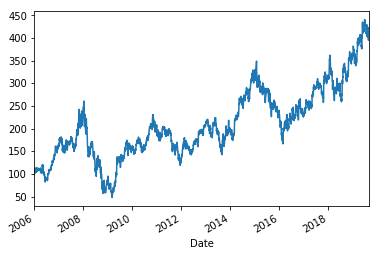

In [6]:
data.Close.plot()
plt.show()

In [7]:
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100
  

print(min(data.Close))  
print(max(data.Close))
roundup(max(data.Close))

47.81
440.95


500

In [8]:
data['Close'].isnull().sum(axis = 0)

0

In [0]:
# to make Date index column into a normal column
# data.reset_index(level=0, inplace=True)

In [0]:
# data["Date"] = pd.to_datetime(data["Date"]).dt.strftime("%Y%m%d").astype(int)

In [9]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-26,407.0,414.00,392.85,411.65,411.65,26701988
2019-08-27,412.8,420.50,411.25,418.60,418.60,28793372
2019-08-28,418.0,418.25,409.70,412.95,412.95,12154347
2019-08-29,409.9,410.80,399.35,404.40,404.40,30331105
2019-08-30,406.5,412.85,402.65,409.65,409.65,18314194


In [10]:
len(data)

3365

In [0]:
# data['Date'].isnull().sum(axis = 0)

In [0]:
series = data.Close.values.astype('float32')

In [12]:
len(series)

3365

In [0]:
timestep = [i for i in range(len(series))]
timestep = np.array(timestep)

In [14]:
timestep

array([   0,    1,    2, ..., 3362, 3363, 3364])

In [15]:
ro=float(roundup(max(series)))
print(ro)

500.0


In [0]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

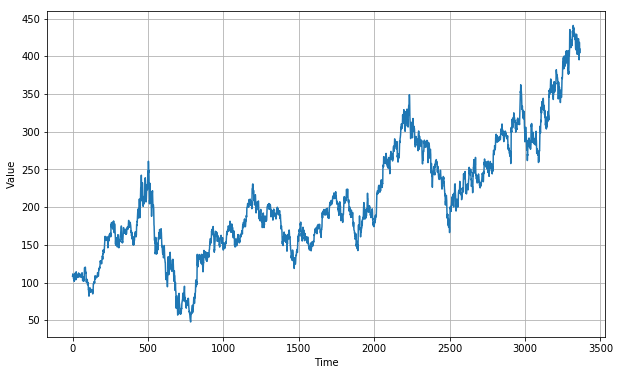

In [17]:
plt.figure(figsize=(10, 6))
plot_series(timestep, series)

In [0]:
# plt.figure(figsize=(10, 6))
# data.Close.plot()
# plt.plot(data.index, data.Close)
# plt.grid(True)
# plt.show()

In [0]:
split_time = 3000
time_train = timestep[:split_time]
x_train = series[:split_time]
time_valid = timestep[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 100
shuffle_buffer_size = 100

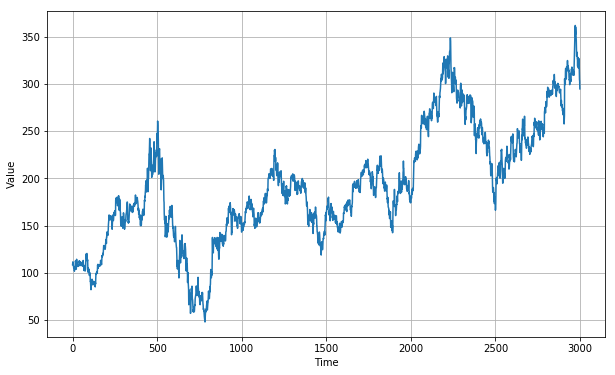

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_train,x_train)

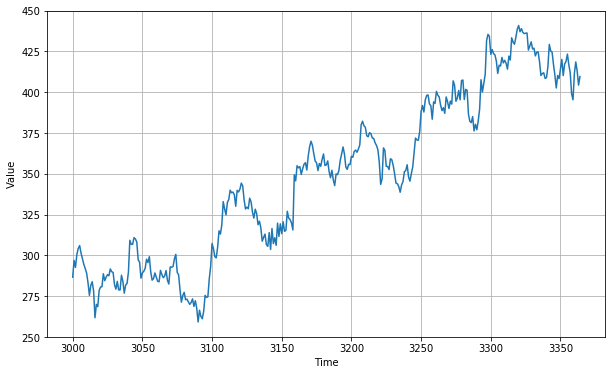

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid,x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
filepath="cp/weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
!mkdir cp

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=6,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * ro)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

W0901 13:49:59.986363 140282053453696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(3000,)
Epoch 1/100
30/30 [==============================] - 9s 285ms/step - loss: 238.7681 - mae: 238.2303
Epoch 2/100
30/30 [==============================] - 5s 154ms/step - loss: 238.6939 - mae: 238.1897
Epoch 3/100
30/30 [==============================] - 5s 155ms/step - loss: 238.6473 - mae: 238.1432
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 238.5946 - mae: 238.0907
Epoch 5/100
30/30 [==============================] - 5s 155ms/step - loss: 238.5374 - mae: 238.0336
Epoch 6/100
30/30 [==============================] - 5s 155ms/step - loss: 238.4751 - mae: 237.9715
Epoch 7/100
30/30 [==============================] - 5s 153ms/step - loss: 238.4043 - mae: 237.9007
Epoch 8/100
30/30 [==============================] - 5s 155ms/step - loss: 238.3234 - mae: 237.8201
Epoch 9/100
30/30 [==============================] - 5s 153ms/step - loss: 238.2324 - mae: 237.729

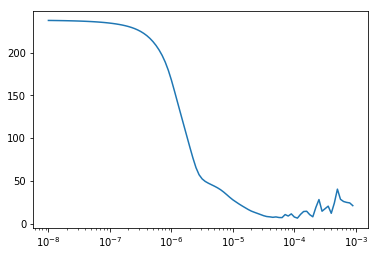

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size=30, batch_size=32, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * ro)
])


optimizer = tf.keras.optimizers.Adam(lr=4e-5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=1000,callbacks=[checkpoint], validation_data=test_set)

Epoch 1/1000
     30/Unknown - 9s 312ms/step - loss: 158.9253 - mae: 159.4398
Epoch 00001: val_loss improved from inf to 159.08302, saving model to cp/weights-01-159.08.hdf5
30/30 [==============================] - 11s 368ms/step - loss: 158.9253 - mae: 159.4398 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/1000
29/30 [============================>.] - ETA: 0s - loss: 114.0297 - mae: 114.5288
Epoch 00002: val_loss did not improve from 159.08302
30/30 [==============================] - 5s 169ms/step - loss: 115.2103 - mae: 115.3715 - val_loss: 178.1680 - val_mae: 176.7387
Epoch 3/1000
29/30 [============================>.] - ETA: 0s - loss: 95.9733 - mae: 96.4722
Epoch 00003: val_loss improved from 159.08302 to 155.96355, saving model to cp/weights-03-155.96.hdf5
30/30 [==============================] - 5s 168ms/step - loss: 97.2202 - mae: 97.3623 - val_loss: 155.9635 - val_mae: 154.5249
Epoch 4/1000
29/30 [============================>.] - ETA: 0s - loss: 86.0934 - mae: 86.5922


In [29]:
#total epoch=2000
history = model.fit(train_set,epochs=400,callbacks=[checkpoint], validation_data=test_set)

Epoch 1/400
     30/Unknown - 5s 166ms/step - loss: 10.2053 - mae: 10.5608
Epoch 00001: val_loss did not improve from 12.36601
30/30 [==============================] - 5s 176ms/step - loss: 10.2053 - mae: 10.5608 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/400
29/30 [============================>.] - ETA: 0s - loss: 9.7394 - mae: 10.2145
Epoch 00002: val_loss did not improve from 12.36601
30/30 [==============================] - 5s 175ms/step - loss: 10.1394 - mae: 10.5004 - val_loss: 19.3462 - val_mae: 19.3599
Epoch 3/400
29/30 [============================>.] - ETA: 0s - loss: 9.7478 - mae: 10.2221
Epoch 00003: val_loss did not improve from 12.36601
30/30 [==============================] - 5s 176ms/step - loss: 10.1808 - mae: 10.5316 - val_loss: 21.0664 - val_mae: 21.0734
Epoch 4/400
29/30 [============================>.] - ETA: 0s - loss: 9.7038 - mae: 10.1772
Epoch 00004: val_loss did not improve from 12.36601
30/30 [==============================] - 5s 171ms/step - loss: 

In [0]:
model.load_weights("cp/weights-170-12.15.hdf5")

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

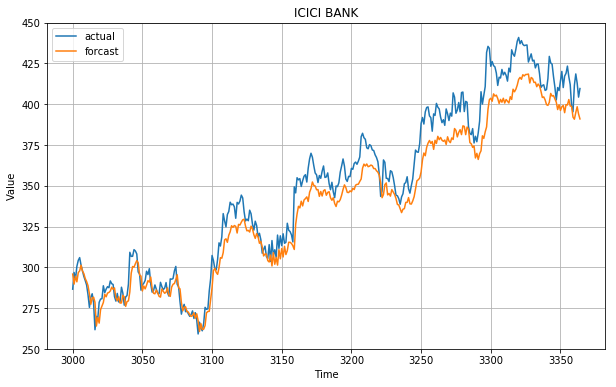

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid,label='actual')
plt.plot(time_valid, rnn_forecast,label='forcast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('ICICI BANK')
plt.legend()
plt.grid(True)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, rnn_forecast)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.07319